# About

The Iraq-Oncology Teaching Hospital/National Center for Cancer Diseases (IQ-OTH/NCCD) lung cancer dataset was collected in the above-mentioned specialist hospitals over a period of three months in fall 2019. It includes CT scans of patients diagnosed with lung cancer in different stages, as well as healthy subjects. IQ-OTH/NCCD slides were marked by oncologists and radiologists in these two centers. The dataset contains a total of 1190 images representing CT scan slices of 110 cases (see Figure 1). These cases are grouped into three classes: normal, benign, and malignant. of these, 40 cases are diagnosed as malignant; 15 cases diagnosed with benign, and 55 cases classified as normal cases. The CT scans were originally collected in DICOM format. The scanner used is SOMATOM from Siemens. CT protocol includes: 120 kV, slice thickness of 1 mm, with window width ranging from 350 to 1200 HU a and window center from 50 to 600 were used for reading. with breath-hold at full inspiration. All images were de-identified before performing analysis. Written consent was waived by the oversight review board. The study was approved by the institutional review board of participating medical centers. Each scan contains several slices. The number of these slices range from 80 to 200 slices, each of them represents an image of the human chest with different sides and angles. The 110 cases vary in gender, age, educational attainment, area of residence, and living status. Some of them are employees of the Iraqi ministries of Transport and Oil, others are farmers and gainers. Most of them come from places in the middle region of Iraq, particularly, the provinces of Baghdad, Wasit, Diyala, Salahuddin, and Babylon.


We have merged the following dataset entitled Chest CT-Scan images Dataset (https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images)into the above dataset to increase the number of images used for training. The tool https://github.com/OmdenaAI/myanmar-chapter-chest-x-rays/blob/cancer-detection-model-tph/src/visualizations/cancer-detection-model/merge_datasets.ipynb was used to merge the two datasets. The Chest CT-Scan images dataset classified Adenocarcinoma, Large cell carcinoma, Squamous cell carcinoma and normal. All the non-normal images are treated as malignant in the merged dataset.

# Acknowledgements

This notebook is based on https://www.kaggle.com/code/adityamahimkar/lung-cancer-prediction-on-image-data by ADITYA MAHIMKAR

## Link to research paper

https://www.researchgate.net/publication/355647879_Computer-Aided_Detection_of_Lung_Cancer_from_CT-scan_Images_with_Visual_Insights_using_Deep_Convolutional_Neural_Network

### Accuracy of tested models from paper

TBD anyone know how to left justify a table?

|Architecture |Loss Non-Weighting |Loss Weighting |Accuracy Non-Weighting |Accuracy Weighting
-----|-----|-----|-----|-----
CNN|38.26|34.49|84.82|90.1
ResNet50V2|35.02|22.80|95.54|98.2
Xception|10.02|10.20|98.21|99.1

# Import Packages

In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator

import cv2
import datetime as dt
import glob
import itertools
from keras import models, layers, optimizers
from keras.applications import Xception
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, \
     Add, Dense, BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D


In [2]:
# If you are running from colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    print('Running on CoLab')
    directory = r'/content/drive/Shareddrives/cancer-detection-model/MERGED The IQ-OTHNCCD lung cancer dataset'
else:
    # If you want to run local
    print('Not running on CoLab')
    directory = r'../../data/cancer-detection-model/MERGED The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on CoLab


# Useful functions

In [3]:
def output_countplot(df, x, order=None, hue=None, figsize=None, title=None):
    '''Output a customized nice looking standardized countplot
        :df: DataFrame to use
        :x: The x axis variable to use in the plot
        :order: The y axis variable to use in the plot default is None
        :hue: The hue variable to use in the plot default is None
        :figsize: The figure size tuple to use in the plot default is None
        :title: The title to use default is Countplot: for {}
    '''

    if (title is None):
        title = 'Countplot for {}'.format(x)

        if (hue is not None):
            title += ' with hue of {}'.format(hue)

    # Use default figsize if not provided
    if (figsize is None):
        figsize=(15,5);

    plt.figure(figsize=figsize);

    plt.xticks(rotation=45);
    plt.rcParams["figure.figsize"] = [7.0, 3.5]
    plt.rcParams["figure.autolayout"] = True

    # Ouput count plot
    ax = sns.countplot(data=df,x=x,order=order,hue=hue);

    # output the amounts on top of the bars
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + (p.get_height()*0.01)

        value = '{:.1f}'.format(p.get_height())

        if (pd.isna(x) or pd.isna(y) or pd.isna(value)):
            continue

        ax.text(x, y, value, ha="center")

    plt.title(title);
    plt.show();


def output_image_histogram(img, title):
    '''Output image display and associated hostogram
        :img:Image to display
        :title: title to output
    '''
    num_columns = 2
    fig, (ax1, ax2) = plt.subplots(1, num_columns)
    fig.suptitle(title)

    ax1.imshow(img)
    ax2.hist(img.ravel(),256,[0,256])

def process_normalize(directory, categories, image_size):
    '''Process and normalize images
        :directory: Root directory of images
        :categories: Categories of diagnosis
        :image_size: Target image size to resize
    '''
    data = []
    X, y = [], []

    for category_index, category in enumerate(categories):
        path = os.path.join(directory, category)

        # Iterate through images and capture image data, resize it and capture category index
        for file in os.listdir(path):
            filepath = os.path.join(path, file)
            img = cv2.imread(filepath, 0)

            # resize the image
            img = cv2.resize(img, (image_size, image_size))
            data.append([img, category_index])

    random.shuffle(data)

    # Split out the image and category data
    image_data, category_data = map(list, zip(*data))
    # Convert the category index into a vector ala [0, 1, 0] because we do
    # not want to imply in the model that index 0 is not as good as 1 and 2 is better than 1 etc.
    y = keras.utils.to_categorical(category_data)

    X = np.array(image_data).reshape(-1, image_size, image_size, 1)

    print('X counts:', X.shape)
    print('y counts:', y.shape)

    # Normalize image values to be between the values of 0 and 1
    X = X / 255.0
    y = np.array(y)

    return X, y

def output_model_results(model, x_valid, y_valid, history):
    '''Output confusion matrix and loss/accuracy plots
        :model: NN model
        :x_valid: X validation dataset
        :y_valid: y validation dataset
        :history: History results from fit
    '''
    y_pred = np.argmax(model.predict(x_valid), axis=1)

    print(classification_report(np.argmax(y_valid, axis=1), y_pred))
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


# Data Analysis

In [4]:
size_data = []
file_data = []
category_data = []
for category_index, category in enumerate(categories):
    path = os.path.join(directory, category)

    for file in os.listdir(path):
        category_data.append(category)
        filepath = os.path.join(path, file)
        file_data.append(filepath)
        image_shape = imageio.v3.imread(filepath).shape
        height, width = image_shape[0], image_shape[1]
        size_data.append('{} x {}'.format(height, width))


image_meta_df = pd.DataFrame()
image_meta_df['Filename'] = file_data
image_meta_df['Category'] = category_data
image_meta_df['Size'] = size_data
image_meta_df.head()

Filename      Category       Size
0  /content/drive/Shareddrives/cancer-detection-m...  Bengin cases  512 x 512
1  /content/drive/Shareddrives/cancer-detection-m...  Bengin cases  512 x 512
2  /content/drive/Shareddrives/cancer-detection-m...  Bengin cases  512 x 512
3  /content/drive/Shareddrives/cancer-detection-m...  Bengin cases  512 x 512
4  /content/drive/Shareddrives/cancer-detection-m...  Bengin cases  512 x 512

In [5]:
image_meta_df.shape

(2097, 3)

- There are 2097 images in our dataset

## Visualizing Categories and Image sizes

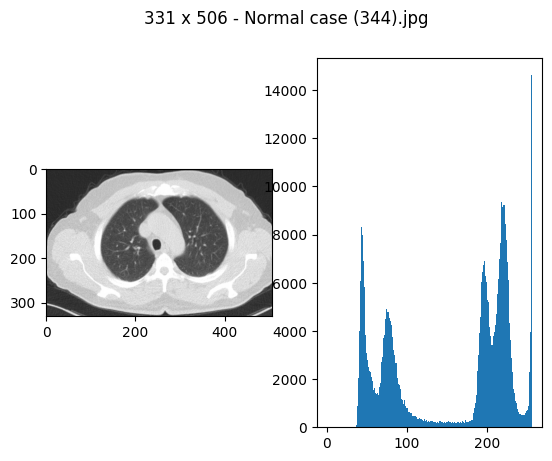

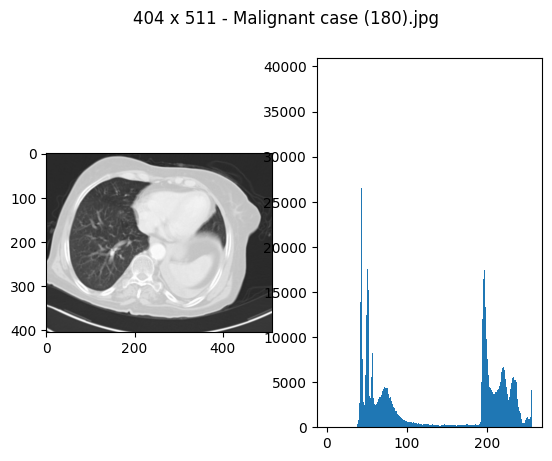

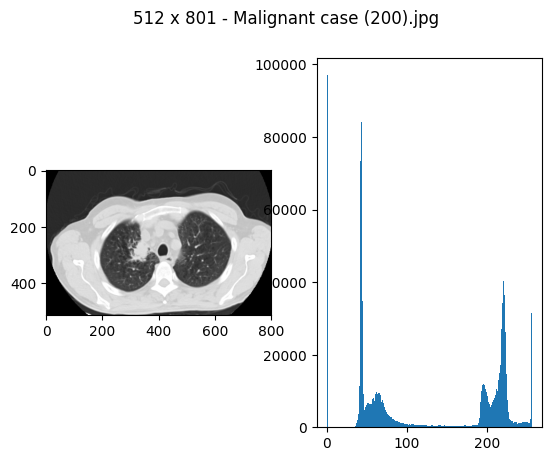

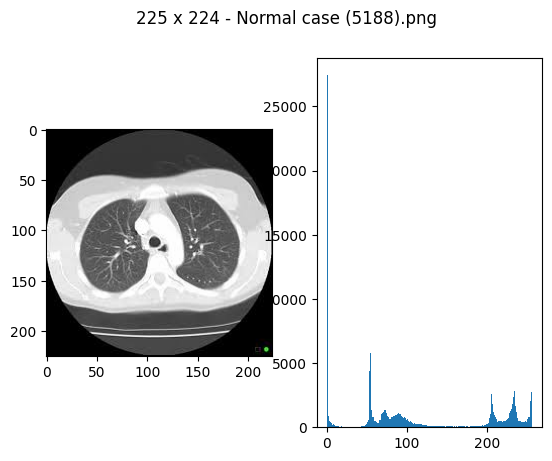

In [6]:
# Build adictionary of oddly sized images
odd_file_dict = {}
odd_file_dict['331 x 506'] = image_meta_df[image_meta_df['Size'] == '331 x 506'].Filename
odd_file_dict['404 x 511'] = image_meta_df[image_meta_df['Size'] == '404 x 511'].Filename
odd_file_dict['512 x 801'] = image_meta_df[image_meta_df['Size'] == '512 x 801'].head(1).Filename
odd_file_dict['225 x 224'] = image_meta_df[image_meta_df['Size'] == '225 x 224'].head(12).Filename

for k, v in odd_file_dict.items():
    filepath = v.iloc[0]
    img = cv2.imread(filepath)
    output_image_histogram(img, '{} - {}'.format(k, os.path.basename(filepath)))

plt.show()

- The oddly shaped images look reasonable.
- Note the two malignant cases show a similar second peak around 40 that the other malignant image showed.

# Preprocess and normalize images and prepare dependent and independent variables

### 256x256 resize and normalization

In [7]:
X_256, y_256 = process_normalize(directory, categories, 256)

X counts: (2097, 256, 256, 1)
y counts: (2097, 3)


# Preparing Data

## Train, test and split for the 256x256 dataset, 80, 10, 10;    train, valid, test

In [8]:
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X_256, y_256, random_state=10, stratify=y_256, test_size=0.2)

print('X train length {}, dimensions {}'.format(len(X_train), X_train.shape))
print('X valid_test length {}, dimensions {}'.format(len(X_valid_test),X_valid_test.shape))

X train length 1677, dimensions (1677, 256, 256, 1)
X valid_test length 420, dimensions (420, 256, 256, 1)


In [9]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, random_state=10, stratify=y_valid_test, test_size=0.5)

print('X valid length {}, dimensions {}'.format(len(X_valid), X_valid.shape))
print('X test length {}, dimensions {}'.format(len(X_test),X_test.shape))

X valid length 210, dimensions (210, 256, 256, 1)
X test length 210, dimensions (210, 256, 256, 1)


In [10]:
print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)
print(len(X_test), X_test.shape)

1677 (1677, 256, 256, 1)
210 (210, 256, 256, 1)
210 (210, 256, 256, 1)


# CNN Weighted Approach and Augmentation  

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Assuming you have X_train, y_train, X_valid, y_valid loaded with your data

# Count the occurrences of positive samples for each class (labels present)
class_positive_samples = np.sum(y_train, axis=0)
# Calculate the total number of samples in the training set
total_samples = y_train.shape[0]
# Calculate the class weights as the inverse of positive sample frequencies
class_weights = total_samples / (class_positive_samples + 1e-6)  # Adding a small epsilon to avoid division by zero
# Normalize the weights so that the sum of weights is equal to the number of classes
class_weights /= np.sum(class_weights)

# Convert class_weights to a dictionary
class_weights_dict = {class_idx: weight for class_idx, weight in enumerate(class_weights)}



# Create the model
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(16))
model3.add(Dense(3, activation='softmax'))

model3.summary()

# Compile the model using weighted binary cross-entropy
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

# Fit the model with data augmentation and class weights
history = model3.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) // 8,  # You can adjust the steps_per_epoch based on your training dataset size
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(X_valid) // 8,  # You can adjust the validation_steps based on your validation dataset size
    class_weight=class_weights_dict
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0

<ipython-input-11-fe31e1ac9215>:53: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(


Epoch 1/15
209/209 [==============================] - 353s 2s/step - loss: 0.0745 - accuracy: 0.5782 - val_loss: 0.4352 - val_accuracy: 0.5913
Epoch 2/15
 69/209 [========>.....................] - ETA: 3:40 - loss: 0.0506 - accuracy: 0.7047

KeyboardInterrupt: ignored

# **Xception Modelling(Weighted Approach and Augmentation)**

# In this modified Xception implementation, we've replaced the standard convolutional layers in each module with our custom modified depth-wise separable blocks. The Add() layer is used to add a linear residual connection between each module, as you've described.

# Keep in mind that training such a large model with 14 modules might require substantial computational resources. You may need to adjust the model architecture or use smaller models if you encounter memory or performance limitations.

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.optimizers import Adam
import numpy as np

# Assuming you have X_train, y_train, X_valid, y_valid loaded with your data (grayscale images)

# Convert grayscale images to RGB by replicating the single channel three times
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)
X_valid_rgb = np.repeat(X_valid[..., np.newaxis], 3, -1)

# Remove the singleton dimension to match the expected input shape
X_train_rgb = np.squeeze(X_train_rgb, axis=-2)
X_valid_rgb = np.squeeze(X_valid_rgb, axis=-2)

# Rest of the code remains the same

# Count the occurrences of positive samples for each class (labels present)
class_positive_samples = np.sum(y_train, axis=0)
# Calculate the total number of samples in the training set
total_samples = y_train.shape[0]
# Calculate the class weights as the inverse of positive sample frequencies
class_weights = total_samples / (class_positive_samples + 1e-6)  # Adding a small epsilon to avoid division by zero
# Normalize the weights so that the sum of weights is equal to the number of classes
class_weights /= np.sum(class_weights)

# Convert class_weights to a dictionary
class_weights_dict = {class_idx: weight for class_idx, weight in enumerate(class_weights)}

# Define custom modified depth-wise separable block
def modified_depthwise_separable_block(inputs, filters, prefix):
    pointwise_conv = Conv2D(filters, (1, 1), strides=(1, 1), padding='same', activation='relu', name=prefix + '_pointwise')(inputs)
    depthwise_conv = SeparableConv2D(filters, (3, 3), strides=(1, 1), padding='same', activation='relu', name=prefix + '_depthwise')(pointwise_conv)
    return depthwise_conv

# Create the Xception base model
input_tensor = Input(shape=(256, 256, 3))
x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu', name='block1_conv1')(input_tensor)
x = Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)

# Add modified depth-wise separable blocks
for i in range(14):
    x_residual = x
    x = modified_depthwise_separable_block(x, 128, f'block{i+2}_modified_depthwise1')
    x = modified_depthwise_separable_block(x, 128, f'block{i+2}_modified_depthwise2')
    x = modified_depthwise_separable_block(x, 128, f'block{i+2}_modified_depthwise3')

    # Add 1x1 convolution to x_residual to match the number of channels in x
    x_residual = Conv2D(128, (1, 1), strides=(1, 1), padding='same')(x_residual)
    x = Add()([x, x_residual])

x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(64, activation='relu')(x)
output_tensor = Dense(3, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.summary()

# Compile the model using weighted binary cross-entropy and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model with data augmentation and class weights
history = model.fit(
    X_train_rgb,
    y_train,
    batch_size=8,
    epochs=15,
    validation_data=(X_valid_rgb, y_valid),
    class_weight=class_weights_dict
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  18496       ['block1_conv1[0][0]']           
                                )                                                             

# **ADJUSTED VERSION OF XCEPTION**

# In this adjusted version, we reduced the number of filters in the convolutional layers to 16 and 32 in the initial layers, and 64 in the modified depth-wise separable blocks. Additionally, we reduced the number of neurons in the Dense layer to 32. These adjustments should help reduce memory usage while still retaining some of the model's capability for feature extraction and classification.



In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Assuming you have X_train, y_train, X_valid, y_valid loaded with your data (grayscale images)

# Convert grayscale images to RGB by replicating the single channel three times
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)
X_valid_rgb = np.repeat(X_valid[..., np.newaxis], 3, -1)

# Remove the singleton dimension to match the expected input shape
X_train_rgb = np.squeeze(X_train_rgb, axis=-2)
X_valid_rgb = np.squeeze(X_valid_rgb, axis=-2)

# Rest of the code remains the same

# Count the occurrences of positive samples for each class (labels present)
class_positive_samples = np.sum(y_train, axis=0)
# Calculate the total number of samples in the training set
total_samples = y_train.shape[0]
# Calculate the class weights as the inverse of positive sample frequencies
class_weights = total_samples / (class_positive_samples + 1e-6)  # Adding a small epsilon to avoid division by zero
# Normalize the weights so that the sum of weights is equal to the number of classes
class_weights /= np.sum(class_weights)

# Convert class_weights to a dictionary
class_weights_dict = {class_idx: weight for class_idx, weight in enumerate(class_weights)}

# Define custom modified depth-wise separable block
def modified_depthwise_separable_block(inputs, filters, prefix):
    pointwise_conv = Conv2D(filters, (1, 1), strides=(1, 1), padding='same', activation='relu', name=prefix + '_pointwise')(inputs)
    depthwise_conv = SeparableConv2D(filters, (3, 3), strides=(1, 1), padding='same', activation='relu', name=prefix + '_depthwise')(pointwise_conv)
    return depthwise_conv

# Create the Xception base model
input_tensor = Input(shape=(256, 256, 3))
x = Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation='relu', name='block1_conv1')(input_tensor)
x = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)

# Add modified depth-wise separable blocks
for i in range(14):
    x_residual = x
    x = modified_depthwise_separable_block(x, 64, f'block{i+2}_modified_depthwise1')
    x = modified_depthwise_separable_block(x, 64, f'block{i+2}_modified_depthwise2')
    x = modified_depthwise_separable_block(x, 64, f'block{i+2}_modified_depthwise3')

    # Add 1x1 convolution to x_residual to match the number of channels in x
    x_residual = Conv2D(64, (1, 1), strides=(1, 1), padding='same')(x_residual)
    x = Add()([x, x_residual])

x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout layer with a dropout rate of 50% (adjust the rate as needed)
output_tensor = Dense(3, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.summary()

# Compile the model using weighted binary cross-entropy and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model with data augmentation and class weights
history = model.fit(
    X_train_rgb,
    y_train,
    batch_size=8,
    epochs=15,
    validation_data=(X_valid_rgb, y_valid),
    class_weight=class_weights_dict
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 32  4640        ['block1_conv1[0][0]']           
                                )                                                             

# **It is more adjusted**
#In this adjusted version, we reduced the number of modified depth-wise separable blocks to 5 and further reduced the number of filters in those blocks to 64. Additionally, we reduced the number of neurons in the Dense layer to 32. These adjustments should help further reduce memory usage while still retaining some level of model performance. Feel free to experiment with the number of blocks and filter sizes to find a balance between memory usage and model performance that suits your needs.


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Assuming you have X_train, y_train, X_valid, y_valid loaded with your data (grayscale images)

# Convert grayscale images to RGB by replicating the single channel three times
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)
X_valid_rgb = np.repeat(X_valid[..., np.newaxis], 3, -1)

# Remove the singleton dimension to match the expected input shape
X_train_rgb = np.squeeze(X_train_rgb, axis=-2)
X_valid_rgb = np.squeeze(X_valid_rgb, axis=-2)

# Rest of the code remains the same

# Count the occurrences of positive samples for each class (labels present)
class_positive_samples = np.sum(y_train, axis=0)
# Calculate the total number of samples in the training set
total_samples = y_train.shape[0]
# Calculate the class weights as the inverse of positive sample frequencies
class_weights = total_samples / (class_positive_samples + 1e-6)  # Adding a small epsilon to avoid division by zero
# Normalize the weights so that the sum of weights is equal to the number of classes
class_weights /= np.sum(class_weights)

# Convert class_weights to a dictionary
class_weights_dict = {class_idx: weight for class_idx, weight in enumerate(class_weights)}

# Define custom modified depth-wise separable block
def modified_depthwise_separable_block(inputs, filters, prefix):
    pointwise_conv = Conv2D(filters, (1, 1), strides=(1, 1), padding='same', activation='relu', name=prefix + '_pointwise')(inputs)
    depthwise_conv = SeparableConv2D(filters, (3, 3), strides=(1, 1), padding='same', activation='relu', name=prefix + '_depthwise')(pointwise_conv)
    return depthwise_conv

# Create the Xception base model
input_tensor = Input(shape=(256, 256, 3))
x = Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation='relu', name='block1_conv1')(input_tensor)
x = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)

# Add modified depth-wise separable blocks
for i in range(5):  # Use only 5 blocks instead of 14 (in the paper, 14 blocks were used)
    x_residual = x
    x = modified_depthwise_separable_block(x, 64, f'block{i+2}_modified_depthwise1')
    x = modified_depthwise_separable_block(x, 64, f'block{i+2}_modified_depthwise2')
    x = modified_depthwise_separable_block(x, 64, f'block{i+2}_modified_depthwise3')

    # Add 1x1 convolution to x_residual to match the number of channels in x
    x_residual = Conv2D(64, (1, 1), strides=(1, 1), padding='same')(x_residual)
    x = Add()([x, x_residual])

x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout layer with a dropout rate of 50% (adjust the rate as needed)
output_tensor = Dense(3, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.summary()

# Compile the model using weighted binary cross-entropy and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model with data augmentation and class weights
history = model.fit(
    X_train_rgb,
    y_train,
    #batch_size=8,
    epochs=15,
    validation_data=(X_valid_rgb, y_valid),
    class_weight=class_weights_dict
)







Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 32  4640        ['block1_conv1[0][0]']           
                                )                                                           